# IA Frugale

Dans ce TP nous allons présenter des métriques de performance d'un modèle ainsi que des techniques d'optimisation afin de rendre un modèle plus efficace en termes de taille et de temps d'inférence, et minimiser donc son empreinte carbone.

> **Données**

Nous utiliserons un jeu de données très connu en traitement d'image : CIFAR 10. Il s'agit d'images objets appartenant à 10 catégories. Nous utiliserons en particulier un sous ensemble constitué uniquement de 3 catégories sur les 10 : `plane`, `car`, `bird`. Chaque image est de taille `32` (longueur) x `32` (largeur) x `3` (nombre de couches couleurs, i.e. rouge-vert-bleu)

> **Modèles**

Les différentes expérimentations de ce TP seront basées sur des modèles de [réseaux de neurones convolutifs](https://fr.wikipedia.org/wiki/R%C3%A9seau_neuronal_convolutif) classiquement utilisés en traitement d'images. 

La tâche qui sera réalisée par ces modèles est une classification multi-classes.

Nous utiliserons [Pytorch](https://pytorch.org/) comme framework d'entrainement de nos modèles.

> **Métriques**

Nous utiliserons les principales métriques de performance suivante :

* Accuracy, i.e. le taux de bonnes prédictions
* temps d'inférence
* Taille du modèle sur disque
* Emission CO2 du modèle
* Flops : nombre total d'opérations de floating points (décimales) effectuées par le modèle.

# Import

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
torch.set_num_threads(1)
from codecarbon import OfflineEmissionsTracker
import pandas as pd

torch.multiprocessing.set_sharing_strategy('file_system')

In [3]:
import sys
sys.path.append("../src/")

In [4]:
from data_utils import (
    load_cifar10_subset,
    imshow,
    convert_list_batches_to_dataloader
)
from model_utils import (
    create_model_and_optimizer,
    train,
    evaluate,
    get_inference_time,
    get_model_flops,
    prune_model,
    quantize_model,
    get_model_size
)
from plot_utils import plot_bars, plot_histogram
from tqdm.auto import tqdm
import copy

Global seed set to 123
Global seed set to 123


# Chargement et préparation du jeu de données

Pour commencer, nous allons charger les données d'entrainement et de test. Ce chargement peut être effectué à l'aide de la fonction `load_cifar10_subset`.

> Tips : Vous pouvez afficher le contenu et les paramètres d'une fonction en tapant la commande `??ma_fonction` dans une cellule du notebook.

In [5]:
??load_cifar10_subset

---
**Exercice 1** : 

* charger les données d'entrainement et de test à l'aide de la fonction `load_cifar10_subset`
* Afficher quelques exemples d'images à l'aide de la fonction
* Initialiser des Dataframes pandas vides avec deux colonnes `Métrique`et `Ratio`, dans lesquelles nous stockerons les différentes métriques ainsi que les ratios (par rapport au modèle baseline) que nous allons calculer plus tard

In [6]:
train_loader, test_loader = load_cifar10_subset()

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

les objets `train_loader` et `test_loader` sont des itérateurs qui renvoient des tuples ($x$, $y$) où :

* $x$ représente un batch d'images qui n'est rien d'autre qu'une matrice de plusieurs dimensions. 

    * la première dimension représente le nombre d'images contenues dans le batch (fixé à `8` dans notre cas et défini dans la fonction `load_cifar10_subset`)
    * la 2ème dimension représente le nombre de couches couleurs (3) 
    * les 3ème et 4ème dimensions correspondent à la largeur et longueur respectivement.
    
    Cette matrice est un objet `Tensor` Pytorch qui est très similaire à un array Numpy. Les valeurs contenues dans cette matrice représentent tout simplement les pixels des images.
* $y$ est le batch de labels correspondant aux images $x$.
    * le label `y = 0` correspond à la classe `plane`
    * le label `y = 1` correspond à la classe `car`
    * le label `y = 2` correspond à la classe `bird`

On peut récupérer un batch d'images et de label de la manière suivante :

In [7]:
x, y = next(iter(test_loader))
print("Dimensions de x : ", x.shape, " \t Dimensions de y :", y.shape)
print("------ x :")
print(x)
print("------ y :")
print(y)

Dimensions de x :  torch.Size([8, 3, 32, 32])  	 Dimensions de y : torch.Size([8])
------ x :
tensor([[[[ 0.2157,  0.3098,  0.3804,  ...,  0.5765,  0.5843,  0.5059],
          [ 0.2000,  0.2784,  0.3412,  ...,  0.5843,  0.5922,  0.4824],
          [ 0.2157,  0.2549,  0.3176,  ...,  0.6157,  0.6000,  0.4824],
          ...,
          [-0.3020, -0.5529, -0.5216,  ..., -0.3020, -0.5373, -0.4745],
          [-0.3020, -0.5294, -0.5059,  ..., -0.5529, -0.5216, -0.4118],
          [-0.2784, -0.5294, -0.5216,  ..., -0.5294, -0.4980, -0.4275]],

         [[ 0.2235,  0.3804,  0.4039,  ...,  0.5373,  0.5843,  0.4353],
          [ 0.2157,  0.4039,  0.4431,  ...,  0.6314,  0.6863,  0.4902],
          [ 0.2078,  0.3961,  0.4510,  ...,  0.6314,  0.6863,  0.4980],
          ...,
          [-0.3804, -0.5843, -0.5216,  ..., -0.0667, -0.3804, -0.4196],
          [-0.3569, -0.5451, -0.4824,  ..., -0.4824, -0.4980, -0.4588],
          [-0.3882, -0.5922, -0.5451,  ..., -0.5059, -0.4902, -0.4667]],

        

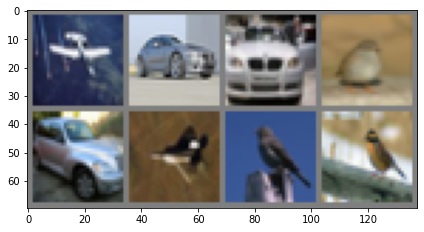

In [8]:
# Afficher quelques exemples d'images pour le jeu d'entrainement
imshow(train_loader)

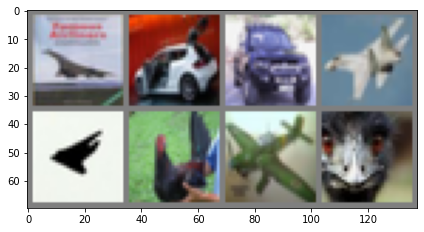

In [9]:
# Afficher quelques exemples d'images pour le jeu de test
imshow(test_loader)

In [10]:
# Initialisation du stockage des résultats

# créer des dataframes pandas vides avec deux colonnes "Métrique" et "Ratio"
df_accuracy = pd.DataFrame(columns=["Métrique", "Ratio"])
df_co2_inference = pd.DataFrame(columns=["Métrique", "Ratio"])
df_size = pd.DataFrame(columns=["Métrique", "Ratio"])
df_flops = pd.DataFrame(columns=["Métrique", "Ratio"])

# Initialiser un dictionnaire vide
dict_inference_time = {}

# Modèle baseline

Pour démontrer l'impact de différentes techniques d'optimisation, nous allons partir d'un modèle `baseline` qui va être notre modèle de référence. Ce modèle a déjà été pré-entraîné et est donc fournis, il suffit de le charger.

Il s'agit d'un réseau convolutif à 4 couches qui a été optimisé lors de 10 epochs sur la donnée d'entraînement. Les spécifications de ce modèle sont :

* 4 couches de convolution de tailles 24, 48, 64 et 64 respectivement
* 2 couches denses de tailles 258 et 128
* 1 couche dense de taille 3 (couche de classification)

Pour plus de détails, voir le script [`src/train_cifar.py`](../src/train_cifar.py) ayant servi à l'entrainement de ce modèle.

In [11]:
# Chargement du modèle 
model_path = "../data/model_cifar_big.pt"
model_large = torch.load(model_path)

In [12]:
# On peut afficher le modèle comme n'importe quel objet python : 
print(model_large)

ConvNet(
  (conv_module): Sequential(
    (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(24, 48, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(48, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1600, out_features=258, bias=True)
    (2): ReLU()
    (3): Linear(in_features=258, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=3, bias=True)
  )
)


---
**Exercice 2** : Calculer les métriques suivantes pour le modèle baseline et les stocker dans les séries précédemment initialisées :

* Accuracy à l'aide de la fonction `evaluate`
* le nombre d'opérations (flops) à l'aide de la fonction `get_model_flops`
* la taille du modèle sur disque à l'aide de la fonction `get_model_size`
* le temps d'inférence estimé pour *10 000 itérations*, à l'aide de la fonction `get_inference_time`
* Emission CO2 pendant le temps d'inférence. Pour cela nous utiliserons la librairie [CodeCarbon](https://mlco2.github.io/codecarbon/index.html) qui permet d'estimer l'émission CO2 d'un traitement algorithmique

> Accuracy

In [13]:
%%time

accuracy_large = evaluate(model=model_large, test_loader=test_loader)
df_accuracy.loc["model_large", "Métrique"] = accuracy_large
df_accuracy.loc["model_large", "Ratio"] = 1

  0%|          | 0/375 [00:00<?, ?it/s]

Accuracy of the network on the 375 test images: 90 %
CPU times: user 14.3 s, sys: 1.26 s, total: 15.5 s
Wall time: 16.2 s


> Flops

In [14]:
flops_large = get_model_flops(model=model_large)

df_flops.loc["model_large", "Métrique"] = flops_large
df_flops.loc["model_large", "Ratio"] = 1

> Taille du modèle

In [15]:
size_large = get_model_size(model=model_large)

df_size.loc["model_large", "Métrique"] = size_large
df_size.loc["model_large", "Ratio"] = 1

Size (MB): 2.630587


> Temps d'inference et emission de CO2

L'outil `CodeCarbon` offre deux modes d'estimation de l'émission CO2:

* Online : lorsqu'on est dans un environnement ayant un accès internet
* Offline : dans un environnement contraint sans accès à internet. Dans ce cas, il faudra préciser le pays dans lequel est située l'infrastructure qu'on cherche à évaluer.

Nous allons utiliser le mode Offline et préciser la France comme pays d'intérêt.

In [16]:
# code du pays, 3 lettres : FRA pour France, DEU for l'allemagne, # TODO
# cf. page https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes
country = "FRA"

In [17]:
# Instanciation l'objet
tracker = OfflineEmissionsTracker(country_iso_code=country)
tracker.start()  # démarrage du monitoring emission CO2
list_duration_large = get_inference_time(model=model_large, nb_iterations=10_000)
emissions_large_inference = tracker.stop()  # fin du monitoring emission CO2

CODECARBON : No CPU tracking mode found. Falling back on CPU constant mode.


  0%|          | 0/10000 [00:00<?, ?it/s]

In [18]:
# Sauvegarder l'emission CO2 

df_co2_inference.loc["model_large", "Métrique"] = emissions_large_inference
df_co2_inference.loc["model_large", "Ratio"] = 1

In [19]:
# Sauvegarder les temps d'inférences sur les 10000 itérations
dict_inference_time["model_large"] = list_duration_large

# Technique d'optimisation n° 1 : l'élagage

L'élagage est une méthode de `compression` qui consiste à annuler (remplacer par des `0`) une partie des poids/couches d'un réseau de neurones afin de le rendre plus performant en termes de temps d'inférence.

Il existe essentiellement deux types d'élagage : 

* Non structuré : on élague (annule) individuellement les poids (neurones) les moins importants, conduisant ainsi à des matrices de poids éparses. Ce type d'élagage peut permettre de réduire l'espace mémoire du modèle, mais pas nécessairement la vitesse d'inférence, à moins de disposer d'un processeur qui implémente des opérations efficientes pour des matrices éparses.
* Structuré : on élague un groupe de neurones, comme par exemple une partie entière des filtres de convolution. Ces groupes de neurones élagués peuvent alors être complètement rétirés du modèle. Cette approche permet donc d'économiser de l'espace mémoire et d'améliorer la performance computationnelle.

Dans ce TP nous allons expérimenter l'élagage structuré.

Un paramètre important est la quantité d'élagage qu'on veut appliquer. Plus on élague le modèle, plus on améliore sa performance et plus on dégrade son accuracy. Il y a donc un compromis à faire à ce niveau.

--- 
**Exercice 3** : 

* Appliquer un élagage à 0.5 (i.e. 50%) au modèle de base et calculer les différentes métriques associées à ce nouveau modèle élagué. On pourra se servir de la fonction `prune_model` pour l'élagage.
* Calculer les différentes métriques définies précédemment pour le modèle élagué.

> Pour le calcul du temps d'inférence et de l'émission CO2, on pourra s'inspirer du code de calcul de CO2 vu plus haut. Le temps d'inférence sera stocké dans la variable `list_duration_large_pruned`, et l'emission CO2 sera stockée dans la variable `emissions_large_inference_pruned`

In [20]:
model_large_pruned = prune_model(model=model_large, pruning_percentage=0.5)

In [21]:
# Calcul de l'accuracy
accuracy_large_pruned = evaluate(model=model_large, test_loader=test_loader)

df_accuracy.loc["model_large_pruned", "Métrique"] = accuracy_large_pruned
df_accuracy.loc["model_large_pruned", "Ratio"] = accuracy_large_pruned/accuracy_large

  0%|          | 0/375 [00:00<?, ?it/s]

Accuracy of the network on the 375 test images: 90 %


In [ ]:
# Calcul du temps d'inférence et de l'emission CO2

tracker = OfflineEmissionsTracker(country_iso_code=country)
tracker.start()
list_duration_large_pruned = get_inference_time(model=model_large_pruned, nb_iterations=10_000)
emissions_large_inference_pruned = tracker.stop()

CODECARBON : No CPU tracking mode found. Falling back on CPU constant mode.


  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
df_co2_inference.loc["model_large_pruned", "Métrique"] = emissions_large_inference_pruned
df_co2_inference.loc["model_large_pruned", "Ratio"] = emissions_large_inference_pruned/emissions_large_inference

dict_inference_time["model_large_pruned"] = list_duration_large_pruned

In [ ]:
# Calcul du Flops
flops_large_pruned = get_model_flops(model=model_large_pruned)

df_flops.loc["model_large_pruned", "Métrique"] = flops_large_pruned
df_flops.loc["model_large_pruned", "Ratio"] = flops_large_pruned/flops_large

In [ ]:
# Calcul de la taille du modèle
size_large_pruned = get_model_size(model=model_large_pruned)
df_size.loc["model_large_pruned", "Métrique"] = size_large_pruned
df_size.loc["model_large_pruned", "Ratio"] = size_large_pruned/size_large

**Evaluation de l'effet de l'élagage**

Pour constater l'effet de l'élagage, nous allons comparer les métriques du modèle avant et après élagage.

Utilisons les fonctions `plot_bars` et `plot_histogram` pour visualiser les diffrentes métriques.

* Commenter l'impact de l'élagage sur les différentes métriques

In [ ]:
plot_bars(df_accuracy, "Accuracy")

In [ ]:
plot_bars(df_co2_inference, "Emission CO2 - Inference")

In [ ]:
plot_bars(df_flops, "Nombre de flops")

In [ ]:
plot_bars(df_size, "Taille du modèle (MB)")

In [ ]:
plot_histogram(dict_inference_time, "Temps d'inférence (s)")

> L'élagage structuré s'avère bénéfique pour toutes nos métriques d'intérêts. Il conserve l'accuracy tout en rendant notre modèle plus léger, plus rapide et donc moins polluant.

> Néanmoins il convient de noter qu'en règle générale, on notera très souvent une perte de points d'accuracy. La conservation de l'accuracy dans notre cas peut être due au fait qu'on a une tâche de classification relativement facile.

---
**Exercice 3-bis** (optionnel)

* Essayer l'élagage non structuré en s'inspirant des sections `Pruning a Module` et `Remove pruning re-parametrization` [de ce tutoriel](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html) ainsi que l'exemple présenté sur [cette page](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.global_unstructured.html#torch.nn.utils.prune.global_unstructured) et comparer son effet par rapport à l'élagage structuré.

* Retenter l'expérience de l'élagage (structuré et/ou non structuré) avec différents niveaux (pourcentage d'élagage) afin de voir l'impact de la quantité d'élagage sur les différentes métriques.

In [ ]:
# Elagage non structuré 
model_large_pruned_unstructured = copy.deepcopy(model_large)

parameters_to_prune = [
    (param, "weight") for name, param in model_large_pruned_unstructured.named_modules()
    if type(param) == torch.nn.Conv2d
]
torch.nn.utils.prune.global_unstructured(parameters_to_prune,
                                         pruning_method=torch.nn.utils.prune.L1Unstructured,
                                         amount=0.5)
for param, name in parameters_to_prune:
    torch.nn.utils.prune.remove(param, name)

In [ ]:
# Calcul de l'accuracy
accuracy_large_pruned_unstructured = evaluate(model=model_large_pruned_unstructured, test_loader=test_loader)
df_accuracy.loc["model_large_pruned_unstructured", "Métrique"] = accuracy_large_pruned_unstructured
df_accuracy.loc["model_large_pruned_unstructured", "Ratio"] = accuracy_large_pruned_unstructured/accuracy_large

In [ ]:
# Calcul du temps d'inférence et de l'emission CO2

tracker = OfflineEmissionsTracker(country_iso_code=country)
tracker.start()
list_duration_large_pruned_unstructured = get_inference_time(model=model_large_pruned_unstructured,
                                                             nb_iterations=10_000)
emissions_large_inference_pruned_unstructured = tracker.stop()

In [ ]:
df_co2_inference.loc["model_large_pruned_unstructured", "Métrique"] = emissions_large_inference_pruned_unstructured
df_co2_inference.loc["model_large_pruned_unstructured", "Ratio"] = emissions_large_inference_pruned_unstructured/emissions_large_inference

dict_inference_time["model_large_pruned_unstructured"] = list_duration_large_pruned_unstructured

In [ ]:
# Calcul du Flops
flops_large_pruned_unstructured = get_model_flops(model=model_large_pruned_unstructured)
df_flops.loc["model_large_pruned_unstructured", "Métrique"] = flops_large_pruned_unstructured
df_flops.loc["model_large_pruned_unstructured", "Ratio"] = flops_large_pruned_unstructured/flops_large

In [ ]:
# Calcul de la taille du modèle
size_large_pruned_unstructured = get_model_size(model=model_large_pruned_unstructured)
df_size.loc["model_large_pruned_unstructured", "Métrique"] = size_large_pruned_unstructured
df_size.loc["model_large_pruned_unstructured", "Ratio"] = size_large_pruned_unstructured/size_large

In [ ]:
plot_bars(df_accuracy, "Accuracy")

In [ ]:
plot_bars(df_co2_inference, "Emission CO2 - Inference")

In [ ]:
plot_bars(df_flops, "Nombre de flops")

In [ ]:
plot_bars(df_size, "Taille du modèle (MB)")

In [ ]:
plot_histogram(dict_inference_time, "Temps d'inférence (s)")

# Technique d'optimisation n° 2 : la quantisation

La quantisation est une méthode permettant de réduire l'empreinte mémoire ainsi que le temps d'inférence d'un modèle en réduisant la précision numérique de ses poids.

En effet, les poids des modèles sont stockées en nombres décimaux avec une précision `FP32`. En convertissant ces poids en une précisant entière `INT8`, on réduit significativement l'espace mémoire pris par ce modèle et aussi le temps d'inférence car les opérations avec des entiers sont généralement plus rapides. Néanmoins les opérations en INT8 sont moins précises et donc peuvent entrainer une dégradation de l'accuracy du modèle.

> **NB** : la quantisation nécessite de convertir les données en entrée du modèle (qui sont généralement en FP32) en INT8, puis de reconvertir la sortie du modèle (qui est en INT8) en FP32. Cette opération de convertion des entrées et sorties à un coût et peu parfois (dans le cas de petits modèles) rendre la quantisation inefficiente, i.e. le modèle quantisé peut être plus lent que le modèle initial.


---
**Exercice 4**

* A l'aide de la fonction `quantize_model`, appliquer la quantisation au modèle de base (model_large)
* Calculer les différentes métriques comme précédemment afin d'évaluer l'impact de la quantization. Commenter l'impact de la quantization.
- Pourquoi les flops baissent drastiquement

In [ ]:
# quantisation
model_large_quantized = quantize_model(model=model_large, data_loader=train_loader)

In [ ]:
# Calcul de l'accuracy
accuracy_large_quantized = evaluate(model=model_large_quantized, test_loader=test_loader)
df_accuracy.loc["model_large_quantized", "Métrique"] = accuracy_large_quantized
df_accuracy.loc["model_large_quantized", "Ratio"] = accuracy_large_quantized/accuracy_large

> Le temps d'inférence sera stocké dans la variable list_duration_large_quantized, et l'emission CO2 sera stockée dans la variable emissions_large_inference_quantized

In [ ]:
# Calcul du temps d'inférence et de l'emission CO2

tracker = OfflineEmissionsTracker(country_iso_code=country)
tracker.start()
list_duration_large_quantized = get_inference_time(model=model_large_quantized, nb_iterations=10_000)
emissions_large_inference_quantized = tracker.stop()

In [ ]:
df_co2_inference.loc["model_large_quantized", "Métrique"] = emissions_large_inference_quantized
df_co2_inference.loc["model_large_quantized", "Ratio"] = emissions_large_inference_quantized/emissions_large_inference
dict_inference_time["model_large_quantized"] = list_duration_large_quantized

In [ ]:
# Flops
flops_large_quantized = get_model_flops(model=model_large_quantized)
df_flops.loc["model_large_quantized", "Métrique"] = flops_large_quantized
df_flops.loc["model_large_quantized", "Ratio"] = flops_large_quantized/flops_large

In [ ]:
# Taille du modèle
size_large_quantized = get_model_size(model=model_large_quantized)
df_size.loc["model_large_quantized", "Métrique"] = size_large_quantized
df_size.loc["model_large_quantized", "Ratio"] = size_large_quantized/size_large

In [ ]:
plot_bars(df_accuracy, "Accuracy")

In [ ]:
plot_bars(df_co2_inference, "Emission CO2 - Inference")

In [ ]:
plot_bars(df_flops, "Nombre de flops")

In [ ]:
plot_bars(df_size, "Taille du modèle (MB)")

In [ ]:
plot_histogram(dict_inference_time, "Temps d'inférence (s)")

* Est-ce toutes les métriques évoluent dans le sens attendu ? Sinon qu'est-ce qui pourrait expliquer les résultats observés ?

> On remarque que le nombre de FLOPS du modèle quantisé est `très faible`. Cette baisse drastique peut induire en erreur car les poids du modèle ayant été transformés en `INT8`, la métrique de "floating points" (opération sur les décimaux) n'est pas pertinente dans ce cas.

> On remarque également que le temps d'inférence ainsi que l'émission CO2 ne se sont pas améliorés, et semblent même se détériorer. Ce constat contre-intuitif pourrait s'expliquer par le coût computationnel introduit par la conversion (FLOAT32 --> INT8 --> FLOAT32) des entrées et sorties de notre modèle quantisé. Dans le cas des petits modèles (comme le nôtre), cette conversion peut contrecarrer le gain de performance issu de la quantisation.

# Technique d'optimisation n° 3 : la distillation

La dernière technique d'optimisation que nous allons aborder est la distillation. L'idée générale de la distillation est de partir d'un "grand modèle" appelé `Teacher` qu'on a déjà entrainé et essayer de distiller la connaissance apprise par ce grand modèle dans un modèle de taille plus réduite appelé `Student`. Ainsi on bénéficie des performances (accuracy par exemple) proches de celles du modèle Teacher tout en améliorant significativement les performances computationnelles avec le modèle Student.

Il existe plusieurs manières de faire de la distillation. Dans ce TP nous allons expérimenter deux approches.

### Distillation simple

Avec la distillation simple, l'idée est d'utiliser le modèle Teacher pour générer des labels sur les données d'entrainement. Ensuite on utilisera ces labels en remplacement des "vrais labels" pour entrainer le model Student.

---
**Exercice 5**

Ecrire une fonction `get_prediction_batches` qui prend en entrée :

* un modèle : dans notre cas ce sera le modèle teacher 
* un jeu de données : dans notre cas ce sera le jeu de donnée d'entrainement

et qui renvoie une liste de tuples. Chaque tuple ($x$, $y'$) de la liste contient un batch $x$ d'images provenant du jeu d'entrée et un batch $y'$ de labels prédit par le modèle pour les images $x$.

> **NB** : les prédictions $y'$ renvoyées ici doivent être des les prédictions du modèle converties en labels entiers.

> **Tips** : on pourra s'inspirer de la fonction `evaluate` qui montre comment on parcourt un jeu de données pour faire des prédictions avec un modèle.

In [ ]:
def get_prediction_batches(model, data_loader):
    list_images_labels = []
    
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            list_images_labels.append((images, predicted))
    return list_images_labels

Utilisons la fonction `get_prediction_batches` pour obtenir les données prédites, avec comme paramètres de cette fonction le modèle baseline `model_large` et les données d'entrainement `train_loader`. Nous Convertirons la liste de données obtenue en objet `DataLoader` à l'aide de la fonction `convert_list_batches_to_dataloader`.

In [ ]:
list_batches = get_prediction_batches(model_large, train_loader)
train_loader_distil = convert_list_batches_to_dataloader(list_batches)

---
**Exercice 7** :

Créer un petit modèle `model_student_simple` et l'optimizer (objet chargé de mettre à jour les poids du modèle pendant l'entrainement) correspondant `optimizer_student_simple`. Pour cela on se servira de fonction `create_model_and_optimizer`. 

> Tips : vous pouvez par exemple créer un modèle avec une seule couche de convolution de taille 12.

In [ ]:
model_student_simple, optimizer_student_simple = create_model_and_optimizer(
    conv_layers_specs=[12],
    linear_layers_specs=[]
)

In [ ]:
print(model_student_simple)

---
**Exercice 8** :

* Procéder à un entrainement du modèle `model_student_simple` sur les données `train_loader_distil` pendant 10 epochs (nombre d'itérations sur l'ensemble de données). La fonction `train` sera utilisée à cet effet
* Evaluer ce modèle avec les différentes métriques comme vu précédemment. Visualisez et commentez les effets de la distillation.

In [ ]:
%%time

# Entrainement
model_student_simple = train(
    model=model_student_simple,
    optimizer=optimizer_student_simple,
    train_loader=train_loader_distil,
    epochs=10
)

In [ ]:
# Calcul de l'accuracy
accuracy_student_simple = evaluate(model=model_student_simple, test_loader=test_loader)
df_accuracy.loc["model_student_simple", "Métrique"] = accuracy_student_simple
df_accuracy.loc["model_student_simple", "Ratio"] = accuracy_student_simple/accuracy_large

In [ ]:
# Calcul du Flops
flops_sudent_simple = get_model_flops(model=model_student_simple)
df_flops.loc["model_student_simple", "Métrique"] = flops_sudent_simple
df_flops.loc["model_student_simple", "Ratio"] = flops_sudent_simple/flops_large

In [ ]:
# Calcul du temps d'inférence et de l'émission CO2
# les temps d'inférence seron stockés dans la variable "list_duration_student_simple"
# L'émission CO2 sera stockée dans la variable "emissions_student_simple_inference"

tracker = OfflineEmissionsTracker(country_iso_code=country)
tracker.start()
list_duration_student_simple = get_inference_time(model=model_student_simple, nb_iterations=10_000)
emissions_student_simple_inference = tracker.stop()

In [ ]:
df_co2_inference.loc["model_student_simple", "Métrique"] = emissions_student_simple_inference
df_co2_inference.loc["model_student_simple", "Ratio"] = emissions_student_simple_inference/emissions_large_inference
dict_inference_time["model_student_simple"] = list_duration_student_simple

In [ ]:
# Calcul de la taille du modèle
size_student_simple = get_model_size(model=model_student_simple)
df_size.loc["model_student_simple", "Métrique"] = size_student_simple
df_size.loc["model_student_simple", "Ratio"] = size_student_simple/size_large

In [ ]:
plot_bars(df_accuracy, "Accuracy")

In [ ]:
plot_bars(df_co2_inference, "Emission CO2 - Inference")

In [ ]:
plot_bars(df_flops, "Nombre de flops")

In [ ]:
plot_bars(df_size, "Taille du modèle (MB)")

In [ ]:
plot_histogram(dict_inference_time, "Temps d'inférence (s)")

### Distillation hybride

Dans le cas de la distillation hybride, on utilise les vrais labels $y$ ainsi que les labels prédits par le modèle Teacher $y'$ pour entrainer le modèle Student. Ainsi la fonction objectif sera une combinaison de la fonction objectif calculée à partir de $y$ et celle calculée à partir de $y'$ 

> $loss = \alpha * loss_y + (1 - \alpha) * loss_{y'}$

$\alpha$ est un paramètre entre 0 et 1, de compromis entre le poids qu'on donne à l'apprentissage avec les vrais labels et l'apprentissage avec les labels générés par le Teacher.

Dans cette approche, le modèle Student apprend de deux sources de connaissance : celle provenant directement des données d'entrainement et celle provenant du modèle Teacher.

---
**Exercice 9**

Créer un petit modèle qui sera utilisé comme Student pour la distillation hybride. Ce modèle devra avoir les mêmes spécifications que le modèle de l'exercice 7 pour qu'on puisse comparer les résultats.

In [ ]:
model_student, optimizer_student = create_model_and_optimizer(
    conv_layers_specs=[12],
    linear_layers_specs=[]
)

In [ ]:
print(model_student)

---
**Exercice 10**

Ecrire une fonction `get_prediction_batches_hybrid` qui prend en entrée :

* un modèle : dans notre cas ce sera le modèle teacher 
* un jeu de données : dans notre cas ce sera le jeu de donnée d'entrainement

et qui renvoie une liste de tuples. Chaque tuple ($x$, $y$, $y'$) de la liste contient un batch d'images $x$ provenant du jeu de données d'entrée, un batch $y$ contenant les vrais labels et un batch $y'$ de prédictions effectuées par le modèle Teacher pour les images $x$.

> **NB** : les prédictions $y'$ renvoyées ici doivent être des prédictions brutes effectuées par le modèle Teacher, i.e. sans qu'elles soient converties en labels entiers.

> **Tips** : se référer à l'exercice 5 pour inspiration

In [ ]:
def get_prediction_batches_hybrid(model, data_loader):
    list_images_labels_hybrid = []
    
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            outputs = model(images)
            list_images_labels_hybrid.append((images, labels, outputs))
    
    return list_images_labels_hybrid

Utilisons la fonction `get_prediction_batches_hybrid` pour obtenir les données prédites, avec comme paramètres de  cette fonction le modèle baseline `model_large` et les données d'entrainement `train_loader`. Ensuite on convertira la liste de données obtenue en objet `DataLoader` à l'aide de la fonction `convert_list_batches_to_dataloader`.

In [ ]:
list_batches = get_prediction_batches_hybrid(model_large, train_loader)
train_loader_distil_hybrid = convert_list_batches_to_dataloader(list_batches)

---
**Exercice 11**

Compléter la ligne 13 de la fonction `distillation_crossentropy_loss` ci-dessous pour calculer la fonction objective totale ci-dessous en se servant de l'équation $loss = \alpha * loss_y + (1 - \alpha) * loss_{y'}$

In [ ]:
def distillation_crossentropy_loss(preds, soft_targets, hard_targets, alpha):
    temperature = 3.0
    scaled_pred = preds / temperature
    soft_targets = torch.nn.functional.softmax(soft_targets, dim=1)
    soft_crossentropy = torch.mean(
        torch.sum(
            -soft_targets * torch.nn.functional.log_softmax(scaled_pred, dim=1),
            dim=1
        )
    )
    loss_teacher = (temperature**2) * soft_crossentropy
    loss_student = torch.nn.functional.cross_entropy(preds, hard_targets)
    loss = alpha*loss_student + (1.0 - alpha)*loss_teacher 
    return loss

La fonction suivante est une fonction utilitaire qui sera utilisée pour faire de la distillation hybride :

In [ ]:
def train_distillation(model, optimizer, train_loader, epochs, alpha):
    
    for epoch in tqdm(range(epochs)):

        running_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels, soft_targets = data

            optimizer.zero_grad()
            preds = model(inputs)
            
            loss = distillation_crossentropy_loss(preds, soft_targets, labels, alpha)
            loss.backward()
            optimizer.step()

            n_iter = 200
            running_loss += loss.item()
            if (i+1) % n_iter == 0:
                print(f'Epoch : {epoch + 1}/{epochs} -------- Iteration : {i + 1:5d} -------- loss: {running_loss / n_iter:.3f}')
                running_loss = 0.0

    print('Finished Training')
    return model

---
**Exercice 12**

* Choisir un paramètre $\alpha$ (ex. 0.75) et entrainer le modèle `model_student` pour 10 epochs à l'aide de la fonction `train_distillation`
* Calculer les différentes métriques pour ce nouveau modèle et puis commenter en comparaison avec les autres approches.

In [ ]:
%%time

model_student = train_distillation(
    model=model_student,
    optimizer=optimizer_student,
    train_loader=train_loader_distil_hybrid,
    epochs=10,
    alpha=0.75
)

In [ ]:
accuracy_student = evaluate(model=model_student, test_loader=test_loader)
df_accuracy.loc["model_student", "Métrique"] = accuracy_student
df_accuracy.loc["model_student", "Ratio"] = accuracy_student/accuracy_large

In [ ]:
flops_sudent = get_model_flops(model=model_student)
df_flops.loc["model_student", "Métrique"] = flops_sudent
df_flops.loc["model_student", "Ratio"] = flops_sudent/flops_large

> Le temps d'inférence sera stocké dans la variable `list_duration_student`, et l'emission CO2 sera stockée dans la variable `emissions_student_inference`

In [ ]:
# Calcul du temps d'inférence et de l'emission CO2

tracker = OfflineEmissionsTracker(country_iso_code=country)
tracker.start()
list_duration_student = get_inference_time(model=model_student, nb_iterations=10_000)
emissions_student_inference = tracker.stop()

In [ ]:
df_co2_inference.loc["model_student", "Métrique"] = emissions_student_inference
df_co2_inference.loc["model_student", "Ratio"] = emissions_student_inference/emissions_large_inference
dict_inference_time["model_student"] = list_duration_student

In [ ]:
size_student = get_model_size(model=model_student)
df_size.loc["model_student", "Métrique"] = size_student
df_size.loc["model_student", "Ratio"] = size_student/size_large

In [ ]:
plot_bars(df_accuracy, "Accuracy")

In [ ]:
plot_bars(df_co2_inference, "Emission CO2 - Inference")

In [ ]:
plot_bars(df_flops, "Nombre de flops")

In [ ]:
plot_bars(df_size, "Taille du modèle (MB)")

In [ ]:
plot_histogram(dict_inference_time, "Temps d'inférence (s)")

* Quel est l'impact de la distillation hybride par rapport à la distillation simple ?

> Comme on s'y attend, les performances computationnelles des deux modèles sont similaires : flops, temps d'inférence, CO2, taille du modèle. Cela s'explique simplement par le fait que les deux modèles ont les mêmes spécifiations (nombre et taille des couches)

> Néanmoins la distillation hybride qui expose le modèle Student à deux sources de connaissance (données d'entrainement et prédictions du Teacher) semble apporter un petit gain en accuracy.